# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
from tensorflow.keras.regularizers import l2


2024-10-04 14:09:52.649618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 14:09:52.649715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 14:09:52.651552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 14:09:52.663393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 14:09:54.427138: W tensorflow/compiler/tf2

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Initialize tokenizer and fit the corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
# Check number of words in the corpus
total_words = len(tokenizer.word_index) + 1 # Total number of unique words
print(f"Total nunber of unique words: {total_words}")

Total nunber of unique words: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
# Create empty list
input_sequences = []

for sentence in corpus:
    token_list = tokenizer.texts_to_sequences([sentence])[0]  # Convert each line to a sequence of integers
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]  # Generate n-gram sequences
        input_sequences.append(n_gram_sequence)  # Append to input_sequences

print(f'Total input sequences: {len(input_sequences)}')


Total input sequences: 15484


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
# Calculate length of the longest sequence
max_sequence_len = max([len(seq) for seq in input_sequences])
print(f"Max sequence length: {max_sequence_len}")

# Pad sequences to ensure they have the same length
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
print(input_sequences[:5])

# Convert sequences into a numpy array
input_sequences = np.array(input_sequences)
print(input_sequences[:5])


Max sequence length: 11
[[   0    0    0    0    0    0    0    0    0    3    2]
 [   0    0    0    0    0    0    0    0    3    2  313]
 [   0    0    0    0    0    0    0    3    2  313 1375]
 [   0    0    0    0    0    0    3    2  313 1375    4]
 [   0    0    0    0    0    0    0    0    0  118 1376]]
[[   0    0    0    0    0    0    0    0    0    3    2]
 [   0    0    0    0    0    0    0    0    3    2  313]
 [   0    0    0    0    0    0    0    3    2  313 1375]
 [   0    0    0    0    0    0    3    2  313 1375    4]
 [   0    0    0    0    0    0    0    0    0  118 1376]]


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
# Prepare predictors and labels
predictors = input_sequences[:, :-1] # All elements except of last one in each sequence
labels = input_sequences[:, -1] # Only the las element in each sequence

print(f'Predictors shape: {predictors.shape}')
print(f'Labels shape: {labels.shape}')

Predictors shape: (15484, 10)
Labels shape: (15484,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
# One hot enconde the labels
labels = ku.to_categorical(labels, num_classes=total_words)

print(f'Labels shape after one-hot encoding: {labels.shape}')


Labels shape after one-hot encoding: (15484, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
model = Sequential([

    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words // 2, activation='relu',kernel_regularizer=l2(0.01)),
    Dense(total_words, activation='softmax')
    
])



2024-10-04 14:09:58.129989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 14:09:58.420748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 14:09:58.421082: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           337500    
                                                                 
 bidirectional (Bidirection  (None, 10, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1687)              170387    
                                                                 
 dense_1 (Dense)             (None, 3375)              5697000   
                                                        

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [12]:
history = model.fit(predictors, labels, epochs=50, verbose=1)


Epoch 1/50


2024-10-04 14:10:14.323422: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-04 14:10:16.390016: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb33bcdf9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-04 14:10:16.390093: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-10-04 14:10:16.430959: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728051016.679395      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/484 [==============================] - 33s 39ms/step - loss: 6.9146 - accuracy: 0.0209
Epoch 2/50
484/484 [==============================] - 10s 20ms/step - loss: 6.5099 - accuracy: 0.0218
Epoch 3/50
484/484 [==============================] - 8s 17ms/step - loss: 6.3973 - accuracy: 0.0262
Epoch 4/50
484/484 [==============================] - 9s 19ms/step - loss: 6.2693 - accuracy: 0.0292
Epoch 5/50
484/484 [==============================] - 10s 20ms/step - loss: 6.1762 - accuracy: 0.0367
Epoch 6/50
484/484 [==============================] - 9s 19ms/step - loss: 6.0958 - accuracy: 0.0398
Epoch 7/50
484/484 [==============================] - 9s 19ms/step - loss: 6.0171 - accuracy: 0.0428
Epoch 8/50
484/484 [==============================] - 9s 18ms/step - loss: 5.9385 - accuracy: 0.0471
Epoch 9/50
484/484 [==============================] - 9s 18ms/step - loss: 5.8362 - accuracy: 0.0526
Epoch 10/50
484/484 [==============================] - 9s 18ms/step - loss: 5.7283 - accuracy: 0.05

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

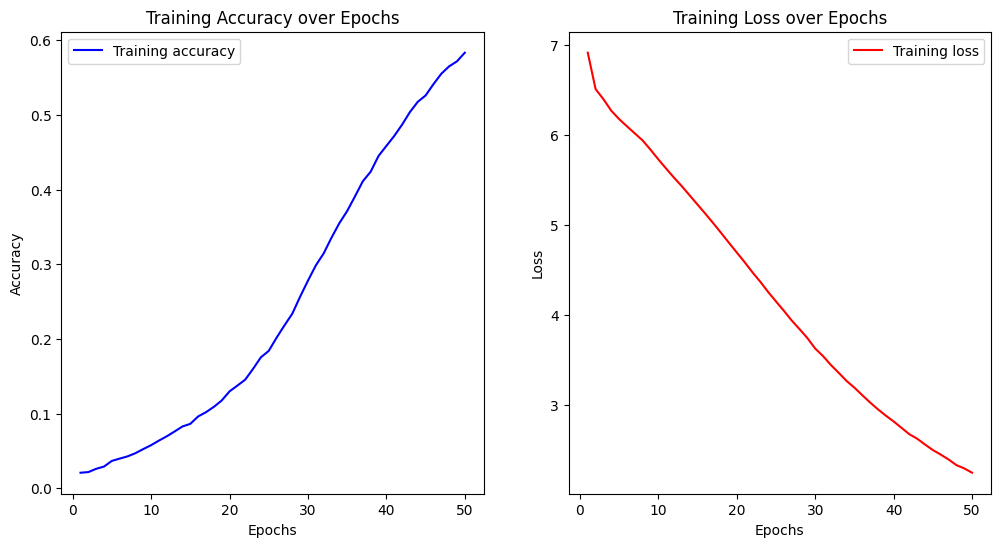

In [13]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss over epochs

# Get the accuracy and loss from the history object
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [14]:
def generate_text(model, tokenizer, seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        # Convert seed_text to a sequence of tokens
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the sequence to match the input length expected by the model
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        # Predict the next word
        predicted = model.predict(token_list, verbose=0)
        # Get the index of the word with the highest probability
        predicted_word_index = predicted.argmax(axis=-1)
        # Convert the index back to a word using the tokenizer
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        # Append the predicted word to the seed text
        seed_text += " " + output_word
    return seed_text

# Variables
seed_text = "Write the text you want the model to use as a starting point"
next_words = 10  # Replace this with the number of words you want to generate

# Generate and print the text
generated_text = generate_text(model, tokenizer, seed_text, next_words, max_sequence_len)
print(generated_text)


Write the text you want the model to use as a starting point leaves ' acquainted dyed acquainted free gone should live young


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [15]:
# Create a loop based on next_words and generate new text
seed_text = "This is the beginning of something"
next_words = 20  # Example: Generate 20 words

for _ in range(next_words):
    # Convert seed_text to a sequence of tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequence to match the input length expected by the model
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    # Get the index of the word with the highest probability
    predicted_word_index = predicted.argmax(axis=-1)
    # Convert the index back to a word using the tokenizer
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break
    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the full generated text
print(seed_text)


This is the beginning of something where thy praise old part write write good thine best have eye alone seem so due was true such art


Experiment with at least 3 different seed_text strings and see what happens!

In [16]:
# Function to generate text with different seed texts
def generate_text(model, tokenizer, seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = predicted.argmax(axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Experimenting with different seed texts
seed_texts = [
    "The sun rises",
    "Once upon a time",
    "In the middle of the night"
]

next_words = 10  # Generate 10 words for each seed text

# Loop through each seed text and generate text
for seed in seed_texts:
    print(f"Seed text: {seed}")
    generated_text = generate_text(model, tokenizer, seed, next_words, max_sequence_len)
    print(f"Generated text: {generated_text}\n")


Seed text: The sun rises
Generated text: The sun rises as happier but to not untrue give sort sort done

Seed text: Once upon a time
Generated text: Once upon a time above that dead worthless wife defaced sang sang pluck make

Seed text: In the middle of the night
Generated text: In the middle of the night hand smell wide wide hand wide wide leaves bell compare

